## Neural Machine Translation using Encoder-Decoder Model and LSTM

In [1]:
import os, sys
from keras.models import Model
from keras.layers import Input, LSTM, GRU, Dense, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import numpy as np
from numpy import array
from numpy import asarray
from numpy import zeros


In [2]:
# Execute this script to set values for different parameters:
BATCH_SIZE = 64
EPOCHS = 20
LSTM_NODES =256
NUM_SENTENCES = 8500
MAX_SENTENCE_LENGTH = 50
MAX_NUM_WORDS = 8500
EMBEDDING_SIZE = 200

##### The language translation model that we are going to develop will translate English sentences into their Italian language counterparts. To develop such a model, we need a dataset that contains English sentences and their Italian translations.

### Data Preprocessing

#### We need to generate two copies of the translated sentence: one with the start-of-sentence token and the other with the end-of-sentence token.



In [6]:
input_sentences = []
output_sentences = []
output_sentences_inputs = []

count = 0
for line in open('E:\Projects\Translation\Data\ita_eng.txt', encoding="utf-8"):
    count += 1
    if count > NUM_SENTENCES:
        break
    if '\t' not in line:
        continue
    input_sentence = line.rstrip().split('\t')[0]
    output = line.rstrip().split('\t')[1]

    output_sentence = output + ' <eos>'
    output_sentence_input = '<sos> ' + output

    input_sentences.append(input_sentence)
    output_sentences.append(output_sentence)
    output_sentences_inputs.append(output_sentence_input)

print("Number of sample input:", len(input_sentences))
print("Number of sample output:", len(output_sentences))
print("Number of sample output input:", len(output_sentences_inputs))

Number of sample input: 8500
Number of sample output: 8500
Number of sample output input: 8500


<>:6: SyntaxWarning: invalid escape sequence '\P'
<>:6: SyntaxWarning: invalid escape sequence '\P'
C:\Users\Namanupadhya\AppData\Local\Temp\ipykernel_24448\4100116135.py:6: SyntaxWarning: invalid escape sequence '\P'
  for line in open('E:\Projects\Translation\Data\ita_eng.txt', encoding="utf-8"):


#### Now randomly print a sentence to analyse your dataset.

In [7]:
print("English sentence: ",input_sentences[180])
print("Italain translation: ",output_sentences[180])

English sentence:  Tom became very famous very quickly.
Italain translation:  Tom diventò famoso molto rapidamente. <eos>


#### You can see the original sentence, " *Tom became very famous very quickly.* " its corresponding translation in the output  " *Tom diventò famoso molto rapidamente* "  Notice, here we have <eos> token at the end of the sentence.

### Tokenization and Padding


#### The next step is tokenizing the original and translated sentences and applying padding to the sentences that are longer or shorter than a certain length, which in case of inputs will be the length of the longest input sentence. And for the output this will be the length of the longest sentence in the output.

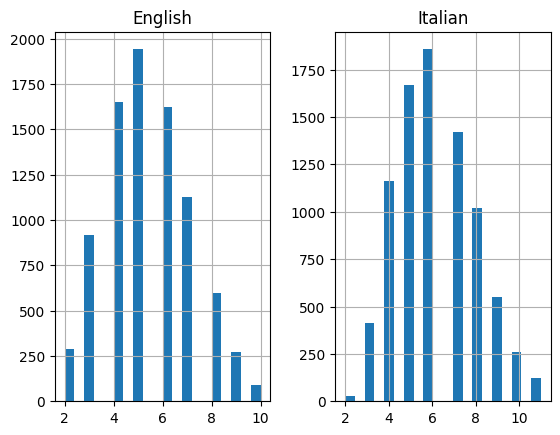

In [8]:
eng_len = []
ita_len = []
for i in input_sentences:
      eng_len.append(len(i.split()))  

for i in output_sentences:
      ita_len.append(len(i.split()))

length_df = pd.DataFrame({'English':eng_len, 'Italian':ita_len})

length_df.hist(bins = 20)
plt.show()

#### For tokenization, the Tokenizer class from the keras.preprocessing.text library can be used. The tokenizer class performs two tasks:

#### 1. It divides a sentence into the corresponding list of word

#### 2. Then it converts the words to integers

#### Also the *word_index* attribute of the Tokenizer class returns a word-to-index dictionary where words are the keys and the corresponding integers are the values. 

In [9]:
input_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
input_tokenizer.fit_on_texts(input_sentences)
input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)
print(input_integer_seq)

word2idx_inputs = input_tokenizer.word_index
print('Total unique words in the input: %s' % len(word2idx_inputs))

max_input_len = max(len(sen) for sen in input_integer_seq)
print("Length of longest sentence in input: %g" % max_input_len)

[[1445, 20, 85, 34, 1], [3, 26, 4, 128, 129, 4, 116], [5, 740, 91, 107], [11, 15, 509], [1, 7, 5, 309, 38, 29, 10, 135], [32, 2, 138, 11], [510, 558, 263, 22, 294], [3, 182, 97, 6, 2028], [5, 1129, 15, 2029], [3, 153, 6, 741, 281], [8, 2, 67, 190, 9], [19, 2030, 13], [666, 22, 19, 2031, 841], [21, 54, 12, 4, 1446], [87, 17, 75, 1], [3, 17, 26, 2, 4, 511, 372, 5, 413], [59, 43, 1447, 9, 1, 50, 24, 70], [14, 28, 191, 31, 2, 164], [37, 608, 46, 667], [27, 18, 2, 141, 56, 842], [3, 15, 148, 1130, 512], [33, 6, 165], [35, 45, 318, 13], [1, 154, 136], [10, 270, 192], [8, 2, 41, 80, 668], [11, 15, 437, 559], [3, 154, 609], [3, 115, 610, 143, 472], [8, 2, 36, 27, 94, 83, 241, 1], [255, 117, 44, 47, 51, 193, 4, 2], [2032, 55, 5, 373, 1131], [102, 75, 1, 4, 8, 9, 473], [2, 474, 55, 242], [1, 249, 414, 112, 353], [1, 270, 20, 843], [2033, 960, 4, 742, 1132], [3, 146, 475, 228, 31, 23, 250], [1, 62, 6, 374], [11, 7, 6, 334, 20, 2034], [3, 17, 12, 187, 144], [3, 154, 282, 22, 1], [48, 63, 1448, 144

In [10]:
output_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, filters='')
output_tokenizer.fit_on_texts(output_sentences + output_sentences_inputs)
output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)
print(output_input_integer_seq)

word2idx_outputs = output_tokenizer.word_index
print('Total unique words in the output: %s' % len(word2idx_outputs))

num_words_output = len(word2idx_outputs) + 1
max_out_len = max(len(sen) for sen in output_integer_seq)
print("Length of longest sentence in the output: %g" % max_out_len)

[[2, 6, 552, 7, 34, 68, 20], [2, 9, 43, 249, 126, 29, 553], [2, 11, 1313, 4, 833], [2, 1023, 727], [2, 3, 5, 10, 631, 18, 78, 8, 333], [2, 728, 3029], [2, 1840, 88, 265, 6, 494], [2, 4, 92, 17, 554], [2, 10, 1024, 555, 3030], [2, 729, 19, 411, 1025], [2, 38, 49, 730, 834], [2, 33, 16, 3031], [2, 412, 15, 42, 3032, 3033], [2, 181, 80, 3034], [2, 456, 4, 26, 266, 6, 20], [2, 4, 43, 8, 44, 1314, 7, 556, 10, 1026], [2, 5, 24, 1841, 8, 3, 106, 230], [2, 4, 17, 48, 413, 21, 185], [2, 23, 14, 835, 11, 64, 836], [2, 22, 5, 108, 45, 1315], [2, 9, 315, 250, 1027, 495, 632], [2, 32, 12, 280], [2, 1316, 219, 7, 104], [2, 3, 4, 130, 316], [2, 31, 5, 381, 210], [2, 231, 8, 55, 3035], [2, 28, 281, 731], [2, 9, 4, 85, 837], [2, 13, 131, 6, 1842, 1028, 557], [2, 109, 22, 6, 182, 68, 70], [2, 5, 496, 299, 35, 4, 243, 6, 127, 21, 185], [2, 4, 71, 3036, 10, 633], [2, 15, 232, 266, 6, 3, 7, 282, 39, 382], [2, 4, 76, 497, 3037], [2, 3, 14, 74, 732, 15, 1317, 1843], [2, 3, 498, 7, 3038], [2, 3039, 27, 5, 184

#### Now the lengths of longest sentence can also be varified from the histogram above. And it can be concluded that English sentences are normally shorter and contain a smaller number of words on average, compared to the translated Italian sentences.

#### Next, we need to pad the input. The reason behind padding the input and the output is that text sentences can be of varying length, however LSTM expects input instances with the same length. Therefore, we need to convert our sentences into fixed-length vectors. One way to do this is via padding.

In [11]:
encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
print("encoder_input_sequences.shape:", encoder_input_sequences.shape)
print("encoder_input_sequences[180]:", encoder_input_sequences[180])

encoder_input_sequences.shape: (8500, 10)
encoder_input_sequences[180]: [  0   0   0   0   1 394  43 446  43 523]


#### Since there are 8500 sentences in the input and each input sentence is of length 10, the shape of the input is now (8500, 10).

#### You may recall that the original sentence at index 180 is *join us*. The tokenizer divided the sentence into two words *join* and *us*, converted them to integers, and then applied pre-padding by adding four zeros at the start of the corresponding integer sequence for the sentence at index 180 of the input list.

In [12]:
print(word2idx_inputs["join"])
print(word2idx_inputs["us"])

1704
85


In the same way, the decoder outputs and the decoder inputs are padded.



In [13]:
decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_input_sequences.shape:", decoder_input_sequences.shape)
print("decoder_input_sequences[180]:", decoder_input_sequences[180])

decoder_input_sequences.shape: (8500, 11)
decoder_input_sequences[180]: [   2    3 1042  642   24  461    0    0    0    0    0]


In [14]:
decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_output_sequences.shape:", decoder_output_sequences.shape)


decoder_output_sequences.shape: (8500, 11)


### Word Embeddings


#### We already converted our words into integers. So what's the difference between integer representation and word embeddings?
#### There are two main differences between single integer representation and word embeddings. With integer reprensentation, a word is represented only with a single integer. With vector representation a word is represented by a vector of 50, 100, 200, or whatever dimensions you like. Hence, word embeddings capture a lot more information about words. Secondly, the single-integer representation doesn't capture the relationships between different words. On the contrary, word embeddings retain relationships between the words. You can either use custom word embeddings or you can use pretrained word embeddings.

#### For English sentences, i.e. the inputs, we will use the GloVe word embeddings. For the translated Italian sentences in the output, we will use custom word embeddings.

#### Let's create word embeddings for the inputs first. To do so, we need to load the GloVe word vectors into memory. We will then create a dictionary where words are the keys and the corresponding vectors are values, 

In [19]:
embeddings_dictionary = dict()

glove_file = open('E:\Projects\Translation\Data\glove.twitter.27B.200d.txt', encoding="utf8")

for line in glove_file:
    rec = line.split()
    word = rec[0]
    vector_dimensions = asarray(rec[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

<>:3: SyntaxWarning: invalid escape sequence '\P'
<>:3: SyntaxWarning: invalid escape sequence '\P'
C:\Users\Namanupadhya\AppData\Local\Temp\ipykernel_24448\2896886023.py:3: SyntaxWarning: invalid escape sequence '\P'
  glove_file = open('E:\Projects\Translation\Data\glove.twitter.27B.200d.txt', encoding="utf8")


#### Recall that we have 3690 unique words in the input. We will create a matrix where the row number will represent the integer value for the word and the columns will correspond to the dimensions of the word. This matrix will contain the word embeddings for the words in our input sentences.



In [20]:
num_words = min(MAX_NUM_WORDS, len(word2idx_inputs) + 1)
embedding_matrix = zeros((num_words, EMBEDDING_SIZE))
for word, index in word2idx_inputs.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [21]:
print(embeddings_dictionary["join"])

[-3.7239e-01  4.7634e-01 -1.9666e-01 -1.1641e+00  1.2820e-02 -4.7063e-01
  4.4522e-01  1.8911e-01  5.6740e-01 -6.1915e-02  2.7159e-01 -1.7613e-01
 -5.4897e-01 -1.6782e-01  3.0910e-01  1.0253e-01  4.3412e-01 -4.0300e-02
  3.4782e-02  2.8017e-01  1.6735e-01 -5.3730e-02 -5.9838e-01 -6.7251e-02
 -7.0371e-01  1.0674e+00  4.1123e-01  2.6227e-01 -3.2041e-01  5.2882e-01
  3.6446e-01  1.3661e-01 -2.2680e-01  6.6556e-01  3.4684e-01 -4.1284e-01
  5.5050e-01  3.5691e-01  3.6985e-01 -3.1312e-01  9.2343e-02  1.7105e-01
 -1.5200e-01  6.4297e-02  2.2327e-01  2.9222e-01 -7.3356e-01 -4.6585e-02
 -2.1011e-01  1.2690e-01  3.1638e-01 -5.1846e-01  2.2601e-02 -1.6426e-01
 -8.4231e-02 -6.5978e-02 -1.4436e-01 -2.2150e-01  4.2886e-01  3.0813e-01
 -1.0191e-03  5.9619e-01  1.7514e-01  5.3788e-01 -6.3198e-01  1.5236e-01
 -1.9268e-01  5.8482e-03  6.8425e-01  5.9576e-01  4.4315e-01  3.5061e-01
  1.8628e-01  8.6317e-01  2.1811e-01 -2.6925e-02  1.4113e-01 -6.5218e-03
 -1.8793e-01 -7.6275e-01 -1.9529e-01 -3.8076e-01  2

In [22]:
print(embedding_matrix[464])

[ 2.11899996e-01  2.22749993e-01  3.30949992e-01 -7.70319998e-03
  2.29310006e-01  1.09370001e-01 -1.33729994e-01 -4.41069990e-01
 -1.98290005e-01  6.88329995e-01 -2.91779995e-01 -1.76679999e-01
 -6.96659982e-01  1.20420001e-01  5.04570007e-02  1.23510003e-01
  4.22910005e-01  6.04620017e-02 -4.10990000e-01  9.76229981e-02
  3.44680011e-01 -2.75040001e-01 -2.61339992e-01 -1.56409994e-01
 -9.10110027e-02  1.13329995e+00  1.20600000e-01  1.91210002e-01
 -4.81350005e-01  5.09480000e-01 -2.94819996e-02  3.07660013e-01
  3.04360002e-01  5.03979981e-01  3.60509992e-01  1.75019994e-01
  2.59719998e-01 -5.44600010e-01 -7.12890029e-01  4.92720008e-02
  2.57360011e-01 -5.01580000e-01 -1.13519996e-01 -2.59099990e-01
 -2.14560002e-01 -2.19730005e-01  6.89559996e-01 -1.06310003e-01
 -3.88980001e-01  4.48680013e-01 -3.63310009e-01  3.33600014e-01
  3.91099989e-01  2.11919993e-01 -2.59380013e-01  6.71619996e-02
  1.99070007e-01  1.77300006e-01  1.86759993e-01 -3.09350014e-01
 -2.13019997e-01  4.88519

#### You can see that the values for the 464th row in the embedding matrix are similar to the vector representation of the word **join** in the GloVe dictionary, which confirms that rows in the embedding matrix represent corresponding word embeddings from the GloVe word embedding dictionary. This word embedding matrix will be used to create the embedding layer for our LSTM model.

### Creates the embedding layer for the input 

In [23]:
embedding_layer = Embedding(num_words, EMBEDDING_SIZE, weights=[embedding_matrix], input_length=max_input_len)


e:\Projects\Translation\venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


### Creating the Model



#### The first thing we need to do is to define our outputs, as we know that the output will be a sequence of words. Recall that the total number of unique words in the output are 7733. Therefore, each word in the output can be any of the 7733 words. The length of an output sentence is 11. And for each input sentence, we need a corresponding output sentence. Therefore, the final shape of the output will be:

In [24]:
decoder_targets_one_hot = np.zeros((
        len(input_sentences),
        max_out_len,
        num_words_output
    ),
    dtype='float32'
)
decoder_targets_one_hot.shape

(8500, 11, 7734)

#### To make predictions, the final layer of the model will be a dense layer, therefore we need the outputs in the form of one-hot encoded vectors, since we will be using softmax activation function at the dense layer. To create such one-hot encoded output, the next step is to assign 1 to the column number that corresponds to the integer representation of the word. 

In [25]:
for i, d in enumerate(decoder_output_sequences):
    for t, word in enumerate(d):
        decoder_targets_one_hot[i, t, word] = 1

#### Next, we need to create the encoder and decoders. The input to the encoder will be the sentence in English and the output will be the hidden state and cell state of the LSTM.

In [26]:
encoder_inputs = Input(shape=(max_input_len,))
x = embedding_layer(encoder_inputs)
encoder = LSTM(LSTM_NODES, return_state=True)

encoder_outputs, h, c = encoder(x)
encoder_states = [h, c]

#### The next step is to define the decoder. The decoder will have two inputs: the hidden state and cell state from the encoder and the input sentence, which actually will be the output sentence with an <sos> token appended at the beginning.

In [27]:
decoder_inputs = Input(shape=(max_out_len,))

decoder_embedding = Embedding(num_words_output, LSTM_NODES)
decoder_inputs_x = decoder_embedding(decoder_inputs)

decoder_lstm = LSTM(LSTM_NODES, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

#### Finally, the output from the decoder LSTM is passed through a dense layer to predict decoder outputs.

In [28]:
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [29]:
# Compilation of the Model
model = Model([encoder_inputs,decoder_inputs], decoder_outputs)
model.compile(
    optimizer='rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 11)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 10, 200)   │    738,200 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 11, 256)   │  1,979,904 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 256),     │    467,968 │ embedding[0][0]   │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 11, 256), │    525,312 │ embedding_1[0][0… │
│                     │ (None, 256),      │            │ lstm[0][1],       │
│                     │ (None, 256)]      │            │ lstm[0][2]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 11, 7734)  │  1,987,638 │ lstm_1[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,699,022 (21.74 MB)

 Trainable params: 5,699,022 (21.74 MB)

 Non-trainable params: 0 (0.00 B)

Let's plot our model to see how it looks.

In [30]:

plot_model(model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [31]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

From the output, you can see that we have two types of input. input_1 is the input placeholder for the encoder, which is embedded and passed through lstm_1 layer, which basically is the encoder LSTM. There are three outputs from the lstm_1 layer: the output, the hidden layer and the cell state. However, only the cell state and the hidden state are passed to the decoder.

Here the lstm_2 layer is the decoder LSTM. The input_2 contains the output sentences with <sos> token appended at the start. The input_2 is also passed through an embedding layer and is used as input to the decoder LSTM, lstm_2. Finally, the output from the decoder LSTM is passed through the dense layer to make predictions.

In [32]:
print(encoder_input_sequences.shape)
print(decoder_input_sequences.shape)
print(decoder_targets_one_hot.shape)


(8500, 10)
(8500, 11)
(8500, 11, 7734)


In [33]:
model.compile(
    optimizer='rmsprop',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [34]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [35]:
history = model.fit([encoder_input_sequences, decoder_input_sequences], decoder_targets_one_hot,
    batch_size=BATCH_SIZE,
    epochs=20,
    callbacks=[es],
    validation_split=0.1,
)


Epoch 1/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 23s 158ms/step - accuracy: 0.4425 - loss: 5.2400 - val_accuracy: 0.5444 - val_loss: 3.3160
Epoch 2/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 18s 148ms/step - accuracy: 0.5553 - loss: 3.1266 - val_accuracy: 0.5540 - val_loss: 3.1617
Epoch 3/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 17s 145ms/step - accuracy: 0.5631 - loss: 2.9445 - val_accuracy: 0.5660 - val_loss: 3.0413
Epoch 4/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 17s 142ms/step - accuracy: 0.5811 - loss: 2.7640 - val_accuracy: 0.5850 - val_loss: 2.9188
Epoch 5/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 17s 141ms/step - accuracy: 0.5963 - loss: 2.5928 - val_accuracy: 0.5996 - val_loss: 2.8115
Epoch 6/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 17s 142ms/step - accuracy: 0.6169 - loss: 2.3999 - val_accuracy: 0.6136 - val_loss: 2.7064
Epoch 7/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 17s 140ms/step - accuracy: 0.6333 - loss: 2.2354 - val_accuracy: 0.6280 - val_loss: 2.6153
Epoch 8/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 17s 141ms/step - accuracy: 0.6496 - loss: 2

In [36]:
model.save('seq2seq_eng-ita.keras')

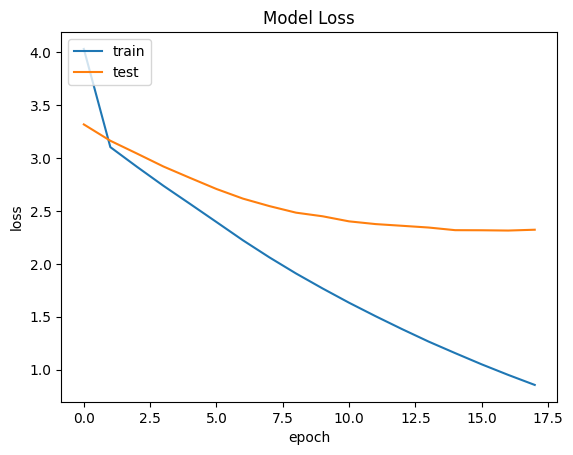

In [38]:
plt.title('Model Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

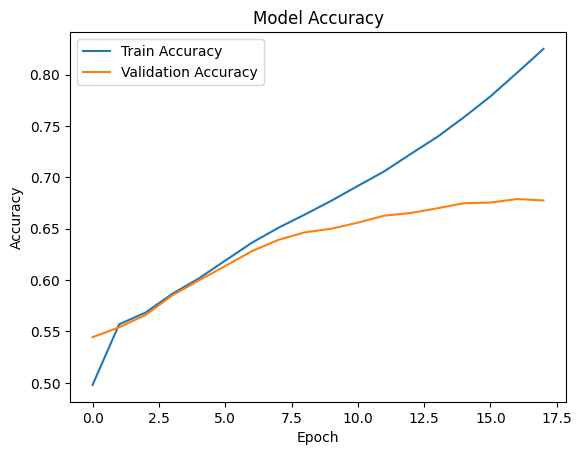

In [39]:

plt.title('Model Accuracy')
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()


In [40]:
encoder_model = Model(encoder_inputs, encoder_states)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
model.load_weights('seq2seq_eng-ita.keras')

e:\Projects\Translation\venv\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [41]:
decoder_state_input_h = Input(shape=(LSTM_NODES,))
decoder_state_input_c = Input(shape=(LSTM_NODES,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)

In [42]:
decoder_outputs, h, c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)


In [43]:
decoder_states = [h, c]
decoder_outputs = decoder_dense(decoder_outputs)

In [44]:
decoder_model = Model(
    [decoder_inputs_single] + decoder_states_inputs,
    [decoder_outputs] + decoder_states
)

In [45]:
plot_model(decoder_model, to_file='model_plot_dec.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


### Making Predictions


#### We want our output to be a sequence of words in the Italian language. To do so, we need to convert the integers back to words. We will create new dictionaries for both inputs and outputs where the keys will be the integers and the corresponding values will be the words.

In [46]:
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

#### The method will accept an input-padded sequence English sentence (in the integer form) and will return the translated Italian sentence. 

In [47]:
def translate_sentence(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<sos>']
    eos = word2idx_outputs['<eos>']
    output_sentence = []

    for _ in range(max_out_len):
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        idx = np.argmax(output_tokens[0, 0, :])

        if eos == idx:
            break

        word = ''

        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)

        target_seq[0, 0] = idx
        states_value = [h, c]

    return ' '.join(output_sentence)

In [48]:
i = np.random.choice(len(input_sentences))
input_seq = encoder_input_sequences[i:i+1]
translation = translate_sentence(input_seq)
print('English Sentence : ', input_sentences[i])
print('Italian translation : ', output_sentences[i].strip("<eos>"))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
English Sentence :  Wow! That looks delicious.
Italian translation :  Wow! Quello sembra delizioso. 


In [52]:
# User Input Translation
import numpy as np

def preprocess_input(sentence, tokenizer, max_len):
    sequence = tokenizer.texts_to_sequences([sentence])
    padded_sequence = pad_sequences(sequence, maxlen=max_len, padding='post')
    return padded_sequence

# Take Italian input from user
user_sentence = input("Enter an Italian sentence: ")
input_seq = preprocess_input(user_sentence, input_tokenizer, max_input_len)

# Translate the sentence
translated_sentence = translate_sentence(input_seq)

print("Translated English sentence:", translated_sentence)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Translated English sentence: voi non vi odiano.
